In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
import heapq
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alx-movie-recommendation-project-2025/sample_submission.csv
/kaggle/input/alx-movie-recommendation-project-2025/movies.csv
/kaggle/input/alx-movie-recommendation-project-2025/imdb_data.csv
/kaggle/input/alx-movie-recommendation-project-2025/genome_tags.csv
/kaggle/input/alx-movie-recommendation-project-2025/genome_scores.csv
/kaggle/input/alx-movie-recommendation-project-2025/train.csv
/kaggle/input/alx-movie-recommendation-project-2025/test.csv
/kaggle/input/alx-movie-recommendation-project-2025/tags.csv
/kaggle/input/alx-movie-recommendation-project-2025/links.csv


In [2]:
#load sample submission data
sample_submission= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/sample_submission.csv')
print('SAMPLE SUBMISSION\n')
sample_submission.head()

SAMPLE SUBMISSION



,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [3]:
#load movies data
movies= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/movies.csv')
print('MOVIES\n')
movies.head()

MOVIES



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
#load imdb data
imdb_data= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/imdb_data.csv')
print('IMDB DATA\n')
imdb_data.head()

IMDB DATA



,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [5]:
#load genome tags
genome_tags= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/genome_tags.csv')
print('GENOME TAGS\n')
genome_tags.head()

GENOME TAGS



,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [6]:
#load genome scores
genome_scores= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/genome_scores.csv')
print('GENOME SCORES\n')
genome_scores.head()

GENOME SCORES



,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [7]:
#load train data
train= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/train.csv')
print('TRAIN DATA\n')
train.head()

TRAIN DATA



,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [8]:
#load test data
test= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/test.csv')
print('TEST DATA\n')
test.head()

TEST DATA



,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [9]:
#load tags data
tags= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/tags.csv')
print('TAGS DATA\n')
tags.head()

TAGS DATA



,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [10]:
#load links data
links= pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2025/links.csv')
print('LINKS DATA\n')
links.head()

LINKS DATA



,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [11]:
#merge genome scores to genome tags and drop duplicates
genome= genome_scores.merge(genome_tags, on= 'tagId', how= 'inner').drop_duplicates()
genome.head()

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s


In [12]:
genome_pivot= genome.pivot(index= 'movieId', columns= 'tag', values= 'relevance').fillna(0)
genome_pivot.head()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [13]:
#merge imdb data to movies
movies= movies.merge(imdb_data[['movieId', 'runtime', 'plot_keywords']], on= 'movieId', how= 'inner').drop_duplicates()
movies.head()

,movieId,title,genres,runtime,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,81.0,toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,104.0,board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,101.0,boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,124.0,black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,106.0,fatherhood|doberman|dog|mansion


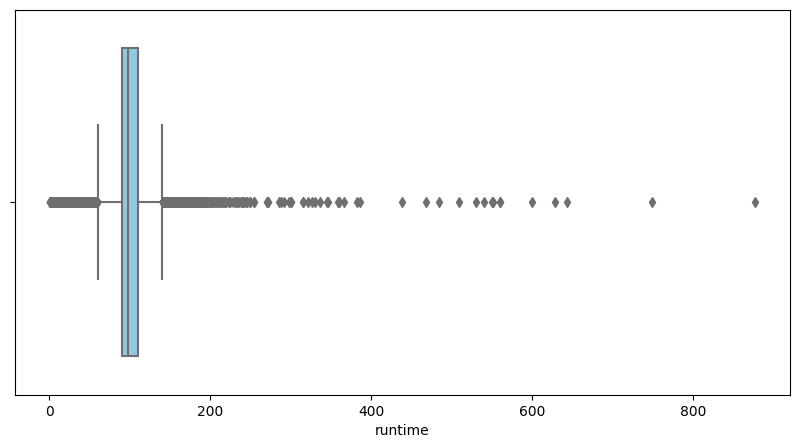

In [14]:
#plot the runtime
plt.figure(figsize= (10,5))
sns.boxplot(data= movies,
            x= 'runtime',
            color= 'skyblue')
plt.show()

In [15]:
movies['runtime'].describe()

count    13521.000000
mean       101.366615
std         29.867424
min          1.000000
25%         90.000000
50%         98.000000
75%        110.000000
max        877.000000
Name: runtime, dtype: float64

In [16]:
#create a function to extract features or categorize runtime
def categorize_runtime(runtime):
    if pd.isna(runtime):
        return 'unknown'
    if runtime < 90:
        return 'short'
    elif 90 <= runtime <=110:
        return 'normal'
    else:
        return 'long'

movies['runtime_category']= movies['runtime'].apply(categorize_runtime)

movies.head()

,movieId,title,genres,runtime,plot_keywords,runtime_category
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,81.0,toy|rivalry|cowboy|cgi animation,short
1,2,Jumanji (1995),Adventure|Children|Fantasy,104.0,board game|adventurer|fight|game,normal
2,3,Grumpier Old Men (1995),Comedy|Romance,101.0,boat|lake|neighbor|rivalry,normal
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,124.0,black american|husband wife relationship|betra...,long
4,5,Father of the Bride Part II (1995),Comedy,106.0,fatherhood|doberman|dog|mansion,normal


In [17]:
columns= ['genres', 'plot_keywords']
for col in columns:
    movies[col]= movies[col].str.replace('|', ', ')
    movies[col]= movies[col].str.lower()

movies.head()

,movieId,title,genres,runtime,plot_keywords,runtime_category
0,1,Toy Story (1995),"adventure, animation, children, comedy, fantasy",81.0,"toy, rivalry, cowboy, cgi animation",short
1,2,Jumanji (1995),"adventure, children, fantasy",104.0,"board game, adventurer, fight, game",normal
2,3,Grumpier Old Men (1995),"comedy, romance",101.0,"boat, lake, neighbor, rivalry",normal
3,4,Waiting to Exhale (1995),"comedy, drama, romance",124.0,"black american, husband wife relationship, bet...",long
4,5,Father of the Bride Part II (1995),comedy,106.0,"fatherhood, doberman, dog, mansion",normal


In [18]:
#use PCA to reduce the dimensionality of genome pivot to just two features
pca= PCA(n_components= 2)
pca_genome_pivot= pca.fit_transform(genome_pivot)
pca_transformed= pd.DataFrame(pca_genome_pivot,columns= ['feature1', 'feature2'], index= genome_pivot.index)
pca_transformed.head()

,feature1,feature2
movieId,,
1,0.796514,2.212835
2,-1.541922,1.597861
3,-1.506092,-0.010219
4,-1.293604,-0.775662
5,-1.694557,-0.185986


In [19]:
movies= movies.merge(pca_transformed, on= 'movieId', how= 'inner').fillna(0)
movies.head()

,movieId,title,genres,runtime,plot_keywords,runtime_category,feature1,feature2
0,1,Toy Story (1995),"adventure, animation, children, comedy, fantasy",81.0,"toy, rivalry, cowboy, cgi animation",short,0.796514,2.212835
1,2,Jumanji (1995),"adventure, children, fantasy",104.0,"board game, adventurer, fight, game",normal,-1.541922,1.597861
2,3,Grumpier Old Men (1995),"comedy, romance",101.0,"boat, lake, neighbor, rivalry",normal,-1.506092,-0.010219
3,4,Waiting to Exhale (1995),"comedy, drama, romance",124.0,"black american, husband wife relationship, bet...",long,-1.293604,-0.775662
4,5,Father of the Bride Part II (1995),comedy,106.0,"fatherhood, doberman, dog, mansion",normal,-1.694557,-0.185986


In [20]:
movies['combined_features'] = (
    movies['genres'].fillna('').astype(str) + ' ' +
    movies['plot_keywords'].fillna('').astype(str) + ' ' +
    movies['runtime_category'].fillna('').astype(str) + ' ' +
    movies['feature1'].fillna(0).astype(str) + ' ' +
    movies['feature2'].fillna(0).astype(str)
)
movies.head()

,movieId,title,genres,runtime,plot_keywords,runtime_category,feature1,feature2,combined_features
0,1,Toy Story (1995),"adventure, animation, children, comedy, fantasy",81.0,"toy, rivalry, cowboy, cgi animation",short,0.796514,2.212835,"adventure, animation, children, comedy, fantas..."
1,2,Jumanji (1995),"adventure, children, fantasy",104.0,"board game, adventurer, fight, game",normal,-1.541922,1.597861,"adventure, children, fantasy board game, adven..."
2,3,Grumpier Old Men (1995),"comedy, romance",101.0,"boat, lake, neighbor, rivalry",normal,-1.506092,-0.010219,"comedy, romance boat, lake, neighbor, rivalry ..."
3,4,Waiting to Exhale (1995),"comedy, drama, romance",124.0,"black american, husband wife relationship, bet...",long,-1.293604,-0.775662,"comedy, drama, romance black american, husband..."
4,5,Father of the Bride Part II (1995),comedy,106.0,"fatherhood, doberman, dog, mansion",normal,-1.694557,-0.185986,"comedy fatherhood, doberman, dog, mansion norm..."


In [21]:
tfid= TfidfVectorizer()
movie_matrix= tfid.fit_transform(movies['combined_features'])

In [22]:
cosine_sim= cosine_similarity(movie_matrix, movie_matrix)

In [23]:
def generate_predictions(movie_title, N= 10):
    ''' 
    N= Number of recommendations
    1. if the movie is not in the dataset (cold start problem
    2. if the movie is in the dataset
    '''
    if movie_title not in movies["title"].values:
        return "Movie Title Not Found"

    idx = movies[movies['title'] == movie_title].index[0]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)
    sim_scores = sim_scores[1 : N + 1]
    
    movie_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    recommendations = movies.iloc[movie_indices][['title', 'genres']].reset_index(drop = True)
    recommendations['similarity_scores'] = similarity_scores

    return recommendations

movie_title = movies.title.iloc[2]
generate_predictions(movie_title, N = 10)

,title,genres,similarity_scores
0,"Crocodile Hunter: Collision Course, The (2002)","adventure, comedy",0.216370
1,Toto le héros (1991),drama,0.181686
2,Meatballs 4 (1992),comedy,0.180717
3,Stefano Quantestorie (1993),"comedy, drama",0.162582
4,Peculiarities of the National Fishing (Osobenn...,comedy,0.154277
5,In the Mood For Love (Fa yeung nin wa) (2000),"drama, romance",0.147479
6,Billy Bathgate (1991),"crime, drama",0.144432
7,All I Want (Try Seventeen) (2002),"comedy, drama, romance",0.143970
8,Eden Lake (2008),"horror, thriller",0.143586
9,Drive Me Crazy (1999),"comedy, romance",0.139593


In [24]:
rating_data = movies.merge(train[['userId', 'movieId' , 'rating']], on = 'movieId', how = "inner")[['title', 'userId', 'rating']]
rating_data.drop_duplicates(inplace = True)
rating_data.head()

,title,userId,rating
0,Toy Story (1995),158849,5.0
1,Toy Story (1995),97203,5.0
2,Toy Story (1995),161871,3.0
3,Toy Story (1995),45117,4.0
4,Toy Story (1995),27431,5.0


In [25]:
indices = pd.Series(range(len(movies)), index = movies['title']).to_dict()
indices

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Waiting to Exhale (1995)': 3,
 'Father of the Bride Part II (1995)': 4,
 'Heat (1995)': 5,
 'Sabrina (1995)': 6,
 'Tom and Huck (1995)': 7,
 'Sudden Death (1995)': 8,
 'GoldenEye (1995)': 9,
 'American President, The (1995)': 10,
 'Dracula: Dead and Loving It (1995)': 11,
 'Balto (1995)': 12,
 'Nixon (1995)': 13,
 'Cutthroat Island (1995)': 14,
 'Casino (1995)': 15,
 'Sense and Sensibility (1995)': 16,
 'Four Rooms (1995)': 17,
 'Ace Ventura: When Nature Calls (1995)': 18,
 'Money Train (1995)': 19,
 'Get Shorty (1995)': 20,
 'Copycat (1995)': 21,
 'Assassins (1995)': 22,
 'Powder (1995)': 23,
 'Leaving Las Vegas (1995)': 24,
 'Othello (1995)': 25,
 'Now and Then (1995)': 26,
 'Persuasion (1995)': 27,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29,
 'Dangerous Minds (1995)': 30,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 

In [26]:
user_ratings = rating_data[rating_data['userId'] == 70347]
# for _, row in user_ratings.iterrows():
#     rated_movie_idx = indices[row['title']
user_ratings

,title,userId,rating
6880,Toy Story (1995),70347,4.0
169771,Babe (1995),70347,3.5
340291,Braveheart (1995),70347,4.0
407999,Apollo 13 (1995),70347,3.5
594836,Don Juan DeMarco (1995),70347,5.0
...,...,...,...
9252017,Paperman (2012),70347,4.0
9311093,"Kings of Summer, The (2013)",70347,4.5
9312681,Monsters University (2013),70347,4.5
9326809,The Spectacular Now (2013),70347,4.0


In [27]:
def content_generate_rating_estimate(title, user, rating_data, k = 20, threshold = 0.0):
    if title not in indices:
        return "Title not found in indices."

    movie_idx = indices[title]

    neighbors = []
    user_ratings = rating_data[rating_data['userId'] == user]

    for _, row in user_ratings.iterrows():
        if row['title'] in indices:
            rated_movie_idx = indices[row['title']]
            
            # Ensure indices are within valid bounds
            if movie_idx >= cosine_sim.shape[0] or rated_movie_idx >= cosine_sim.shape[1]:
                continue
            
            similarity = cosine_sim[movie_idx, rated_movie_idx]
            neighbors.append((similarity, row['rating']))

    k_neighbors = heapq.nlargest(k, neighbors, key = lambda x: x[0]) 
    #This works too: k_neighbors = sorted(neighbors, key = lambda x: x[0], reverse=True)[:k]

    sim_total, weighted_sum = 0, 0
    for sim_score, rating in k_neighbors:
        if sim_score > threshold:
            sim_total += sim_score
            weighted_sum += sim_score * rating

    if sim_total == 0: # Cold-start problem
        return np.mean(rating_data[rating_data['title'] == title]['rating'])

    return weighted_sum / sim_total

content_generate_rating_estimate('Autómata (Automata) (2014)', 46023, rating_data, k = 2, threshold = 3.0)

3.293594306049822

In [28]:
user_id = 46023
user_data = rating_data[rating_data['userId'] == user_id].copy()
user_data['predictions'] = user_data['title'].apply(
    lambda x : np.round(content_generate_rating_estimate(x, user_id, rating_data), 1)
)
user_data

,title,userId,rating,predictions
32380,Jumanji (1995),46023,3.0,2.8
39031,Father of the Bride Part II (1995),46023,3.0,2.8
250315,"Usual Suspects, The (1995)",46023,3.5,3.0
283711,From Dusk Till Dawn (1996),46023,3.5,2.9
309072,Broken Arrow (1996),46023,2.5,2.2
...,...,...,...,...
9517652,Big Hero 6 (2014),46023,2.5,2.4
9524364,The Imitation Game (2014),46023,2.5,2.6
9531651,Dumb and Dumber To (2014),46023,2.0,2.2
9535527,Citizenfour (2014),46023,3.0,2.9


In [29]:
from surprise import SVD, Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from surprise import accuracy

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

In [30]:
train.drop(columns = ['timestamp'], inplace = True)
train.head(2)

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5


In [31]:
reader = Reader()

In [32]:
train_data = Dataset.load_from_df(train, reader)

In [33]:
trainset = train_data.build_full_trainset()

In [34]:
svd = SVD(random_state = RANDOM_STATE)

In [35]:
svd.fit(trainset)

In [36]:
userId = test['userId'].values.tolist()
movieId = test['movieId'].values.tolist()

count = len(userId)
rating = []

for i in range(count):
    result = svd.predict(userId[i], movieId[i])[3]
    rating.append(result)

In [37]:
rating[:3]

[3.0298973528716644, 4.0308413816967565, 3.5065468110479916]

In [38]:
test_pred = pd.DataFrame({
    'Id' : [f"{u}_{m}" for u, m in zip(userId, movieId)],
    'rating' : np.round(rating, 2)
})
test_pred.head()

,Id,rating
0,1_2011,3.03
1,1_4144,4.03
2,1_5767,3.51
3,1_6711,3.89
4,1_7318,3.08


In [39]:
train.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [40]:
userId = train['userId'].values.tolist()
movieId = train['movieId'].values.tolist()
rating = train['rating'].values.tolist()

count = len(userId)
rating = []

for i in range(count):
    result = svd.predict(userId[i], movieId[i])[3]
    rating.append(result)


train_pred = pd.DataFrame({
    'userId' : userId,
    'movieId' : movieId,
    'rating' : rating,
    'pred_rating' : np.round(rating, 2)
})
train_pred.head()

,userId,movieId,rating,pred_rating
0,5163,57669,4.340614,4.34
1,106343,5,4.071443,4.07
2,146790,5459,4.023059,4.02
3,106362,32296,2.358860,2.36
4,9041,366,3.199956,3.20


In [41]:
test_pred.to_csv("predictions.csv", index = False)